# Deconfounding Movie Revenues - Preliminary Results
This is the Pyro implementation of the Deconfounder from Blei-labs "Blessings of Multiple Causes" which investigates actor values by aiming to infer latent confounders that afffect casting and revenue of the movie. <br>

For example: In a James Bond movie, revenue is primarily driven by the actor who plays James Bond and the franchise value that Bond movies carry. Supporting roles like M and Q do not contribute much to revenue. This fact is not captured by traditional linear regression models which bias revenue towards these actors. <br>

The **deconfounder** debiases these predictions by correcting the regression coefficients of these actors and hence, brings the model closer to the actual value of actors to a movie and its revenue.

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
from scipy import sparse
from sklearn.model_selection import train_test_split
pyro.set_rng_seed(101)



import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

In [11]:
X_all = pd.read_csv("D:/Northeastern_Data/Summer_19/CS_7290/project_data/ohe_movies.csv", index_col = 0)
Y = X_all["revenue"].to_numpy()
# Remove title and revenue
X_all = X_all[X_all.columns.difference(['title_x', 'revenue'])]

x_train = X_all

## Probabilistic PCA model:

![Assumed Model](dag_probpca.jpg)


\begin{equation}
\mathbf{z}_{n} \stackrel{iid}{\sim} N(\mathbf{0}, \mathbf{I}_K) \\
\mathbf{w}_{n} \stackrel{iid}{\sim} N(\mathbf{0}, \mathbf{I}_K) \\
\mathbf{x}_n \mid \mathbf{z}_n
\sim Bernoulli(\mathbf{z}_n\mathbf{W})
\end{equation}

In [3]:
# Convert input from dataframe to tensor

x_train_tensors = torch.tensor(x_train.to_numpy(dtype = 'float32'))

In [4]:
def ppca_model(data):
    '''
    the probabilistic PCA model
    '''
    num_datapoints, data_dim = data.shape
    
    latent_dim = 30 # This can be varied
    
    # Parameters for w
    w_mean0 = torch.zeros([latent_dim, data_dim])
    w_std0 = torch.ones([latent_dim, data_dim])
    
    # Parameters for z
    z_mean0 = torch.zeros([num_datapoints, latent_dim])
    z_std0 = torch.ones([num_datapoints, latent_dim])


    w = pyro.sample("w", pyro.distributions.Normal(loc = w_mean0, 
                                                   scale = w_std0))

    z = pyro.sample("z", pyro.distributions.Normal(loc = z_mean0, 
                                                   scale = z_std0))

    linear_exp = torch.matmul(z, w)


    # observe data using the bernoulli likelihood
    
    x = pyro.sample("x", pyro.distributions.Bernoulli(logits = linear_exp), obs = data)

In [5]:
def guide(data):
    '''
    guide function to be used for SVI
    '''
    num_datapoints, data_dim = data.shape
    
    latent_dim = 30 # This can be varied
    
    # To infer w params
    
    qw_mean = pyro.param("qw_mean", torch.zeros([latent_dim, data_dim]))
    qw_stddv = pyro.param("qw_stddv", torch.ones([latent_dim, data_dim]),
                         constraint=constraints.positive)
    
    # To infer z params
    
    qz_mean = pyro.param("qz_mean", torch.zeros([num_datapoints, latent_dim]))
    qz_stddv = pyro.param("qz_stddv", torch.ones([num_datapoints, latent_dim]),
                         constraint=constraints.positive)
    
    w = pyro.sample("w", pyro.distributions.Normal(loc = qw_mean, 
                                                   scale = qw_stddv))
    z = pyro.sample("z", pyro.distributions.Normal(loc = qz_mean, 
                                                   scale = qz_stddv))

## SVI
Takes 45-50 minutes for the entire dataset, but much faster than HMC.

In [6]:
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints
from pyro.optim import Adam

adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)

svi = SVI(ppca_model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000

# do gradient steps
for step in range(n_steps):
    svi.step(x_train_tensors)
    if step % 100 == 0:
        print('.', end='')

....................

In [7]:
# grab the learned variational parameters
qw_m = pyro.param("qw_mean")
qw_s = pyro.param("qw_stddv")

qz_m = pyro.param("qz_mean")
qz_s = pyro.param("qz_stddv")

In [8]:
inferred_z = z = pyro.sample("inf_z", pyro.distributions.Normal(loc = qz_m, 
                                                   scale = qz_s))

In [9]:
inferred_z

tensor([[-0.8238,  0.3975, -0.3530,  ..., -0.5844,  0.8720, -2.3214],
        [-0.1182, -0.2663, -1.1012,  ...,  0.4837,  0.3303, -0.3953],
        [-0.1577, -1.0062, -0.2317,  ...,  0.7573,  1.0345, -0.8094],
        ...,
        [-0.8911,  0.9449, -0.1022,  ..., -0.5388,  0.7644, -0.0901],
        [-0.5784, -0.6226, -0.7015,  ..., -1.0325,  0.5147,  0.2903],
        [-1.0398,  0.0151, -0.5669,  ..., -1.1075,  0.5542, -0.3925]],
       grad_fn=<AddBackward0>)

## Regression and Actor values

We now check if we have debiased actor values given these confounders.

In [96]:
# Regression with confounders
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [97]:
Y_Scaled = StandardScaler().fit_transform(Y.reshape(-1,1))

In [252]:
def fitModel(X, Y, title, test_size=0.8, cat=False, model=LinearRegression()):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    if not cat: 
        score = r2_score(Y_test, Y_pred)
    else:
        score = model.score(X_test, Y_test)
    plt.plot(Y_pred, Y_test, 'o')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    
    print("Root Mean squared Error:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
    #return model.coef_
    return model.coef_, Y_pred, Y_test

### Regression on Revenue with only Actors (no confounders).

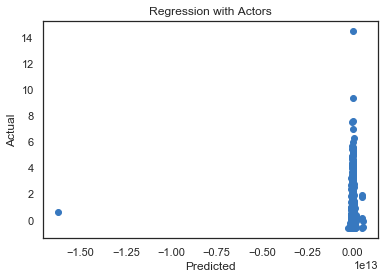

Root Mean squared Error: 314829668702.43286


In [253]:
coef_noCF_Y = fitModel(x_train.to_numpy(), Y_Scaled, title = "Regression with Actors", cat = False)

### Regression on Revenue with Actors and Confounders

In [103]:
data_CF = np.hstack((x_train.to_numpy(), X_CF))

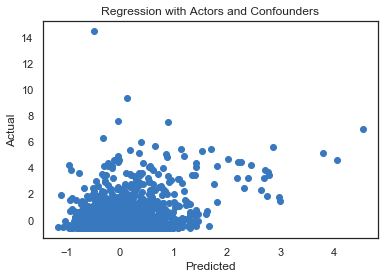

Root Mean squared Error: 0.9681062180714709


In [254]:
coef_X_CF_Y = fitModel(data_CF, Y_Scaled, title = "Regression with Actors and Confounders", cat = False)

RMSE has decreased drastically.

Nowe we see which actors have changed coefficient values and in which direction (i.e overvalued or undervalued).

In [207]:
actor_coefs_noCF = list(coef_noCF_Y[0][0])

In [208]:
actor_coefs_X_CF = list(coef_X_CF_Y[0][0])[:-30]

In [209]:
all_actors = list(x_train.columns)

In [237]:
def findMaxChanges(noCF_coefs, XCF_coefs, actors):
    
    assert(len(noCF_coefs) == len(XCF_coefs))
    fin_list = []
    for i in range(len(noCF_coefs)):
        actor = actors[i]
        diff = XCF_coefs[i] - noCF_coefs[i]       # Difference between coef with CF and without CF
        magnitude = np.linalg.norm(diff)          # How much change
        direction = 'Overvalued' if np.sign(diff) == -1.0 else 'Undervalued'   # In what direction?
        
        # If direction is -ve i.e coef with CF is lesser than coef without CF it means that actor was being overvalued
        
        fin_list.append((actor, magnitude, direction))
        
    # Sort by most changes
    fin_list.sort(key=lambda x: x[1], reverse = True)
    df_toret = pd.DataFrame(fin_list, columns = ['Actor', 'Magnitude', 'Direction'])
    return fin_list, df_toret

In [238]:
tests = findMaxChanges(actor_coefs_noCF, actor_coefs_X_CF, all_actors)

## David Blei's study.

We compared if our overvalued actors are the same as our reference paper found them to be. <br>

Overvalued Brad Pitt, Robert De niro <br>
Undervalued: Nicolas Cage, Cate Blanchett, Antonio Banderas <br>
Most Improved: Ben Affleck <br>

Overvalued actors: Robert De Niro, Brad Pitt

In [240]:
tests[1][tests[1]['Actor'] == 'Robert De Niro']

,Actor,Magnitude,Direction
1988,Robert De Niro,2.911319e+09,Overvalued


In [241]:
tests[1][tests[1]['Actor'] == 'Brad Pitt']

,Actor,Magnitude,Direction
995,Brad Pitt,6.675055e+09,Overvalued


In [242]:
tests[1][tests[1]['Actor'] == 'Nicolas Cage']

,Actor,Magnitude,Direction
1000,Nicolas Cage,6.577418e+09,Undervalued


In [243]:
tests[1][tests[1]['Actor'] == 'Cate Blanchett']

,Actor,Magnitude,Direction
691,Cate Blanchett,9.970243e+09,Undervalued


Undervalued: Nicolas Cage, Cate Blanchett, Antonio Banderas

In [244]:
tests[1][tests[1]['Actor'] == 'Antonio Banderas']

,Actor,Magnitude,Direction
1877,Antonio Banderas,3.166184e+09,Undervalued


In [239]:
tests[1][tests[1]['Actor'] == 'Ben Affleck']

,Actor,Magnitude,Direction
814,Ben Affleck,8.374546e+09,Undervalued


**Is miss Monneyppenny overvalued?** <br>
Looking at who played M in Skyfall: Judi Dench, and who played Bond: Daniel Craig

In [245]:
tests[1][tests[1]['Actor'] == 'Judi Dench']

,Actor,Magnitude,Direction
1667,Judi Dench,3.577081e+09,Overvalued


In [246]:
tests[1][tests[1]['Actor'] == 'Daniel Craig']

,Actor,Magnitude,Direction
2293,Daniel Craig,2.355315e+09,Undervalued


## HMC
Really slow but works without a guide function. This attempt is only with 500 columns and not all 13852 columns.

In [73]:
from pyro.infer.mcmc import HMC, MCMC
# from pyro.infer import mcmc

hmc_kernel = HMC(ppca_model, step_size=0.0855, num_steps=4)

x_new = x_train_tensors[:, :500]

ppca_model(x_new)

mcmc_run = MCMC(hmc_kernel, num_samples=500, warmup_steps=100).run(x_new)

Sample: 100%|███████████████████████████████████| 600/600 [04:05<00:00,  4.62it/s, step size=8.63e-02, acc. rate=0.857]


In [75]:
from pyro.infer import EmpiricalMarginal
posterior_z = EmpiricalMarginal(mcmc_run, 'z')

In [93]:
posterior_z.mean

tensor([[ 0.4385, -2.2742],
        [-0.0849, -2.0328],
        [-0.0924, -1.9028],
        ...,
        [ 0.2301, -2.0688],
        [ 1.1267, -1.4036],
        [ 0.1130, -2.0810]])